In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [69]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [70]:
# Case 1: Prediction in RGB Color Space

In [71]:
# Preparing the dataset
files = ['Consumable', 'Non-Consumable']
address = '/media/debrc/Data/Codings/Meat-Gradation-PROJ/Dataset/Chicken/'

In [72]:
# Loading the image files based on classifications
data = {}
for f in files:
    data[f]=[]
for col in files:
    os.chdir(address+col)
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg'):
            data[col].append(i)

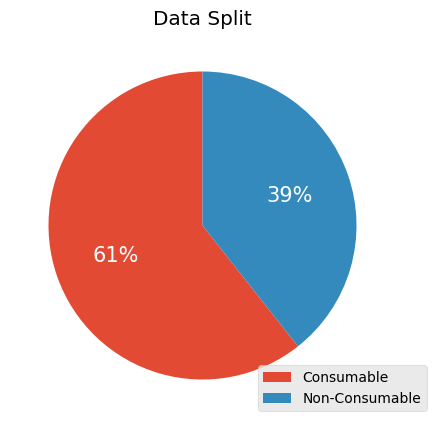

In [73]:
sizes = [len(data['Consumable']), len(data['Non-Consumable'])]
plt.figure(figsize=(10,5), dpi=100)
plt.pie(x=sizes,autopct='%1.0f%%',shadow=False, textprops={'color':"w","fontsize":15}, startangle=90)
plt.legend(files,bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [74]:
width = 100
height = 100

In [75]:
# Converting BGR Images to RGB Color Space
start = time.time()
image_data = []
image_target = []

for title in files:
    os.chdir(address+title)
    counter = 0
    for i in data[title]:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(cv2.resize(img,(width, height)))
        image_target.append(title)
        counter += 1
    clear_output(wait=True)
calculate_time = time.time() - start    
print("Calculate Time",round(calculate_time,5))

Calculate Time 29.76169


In [76]:
# Displaying the dimensionality of the array
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(310, 100, 100, 3)

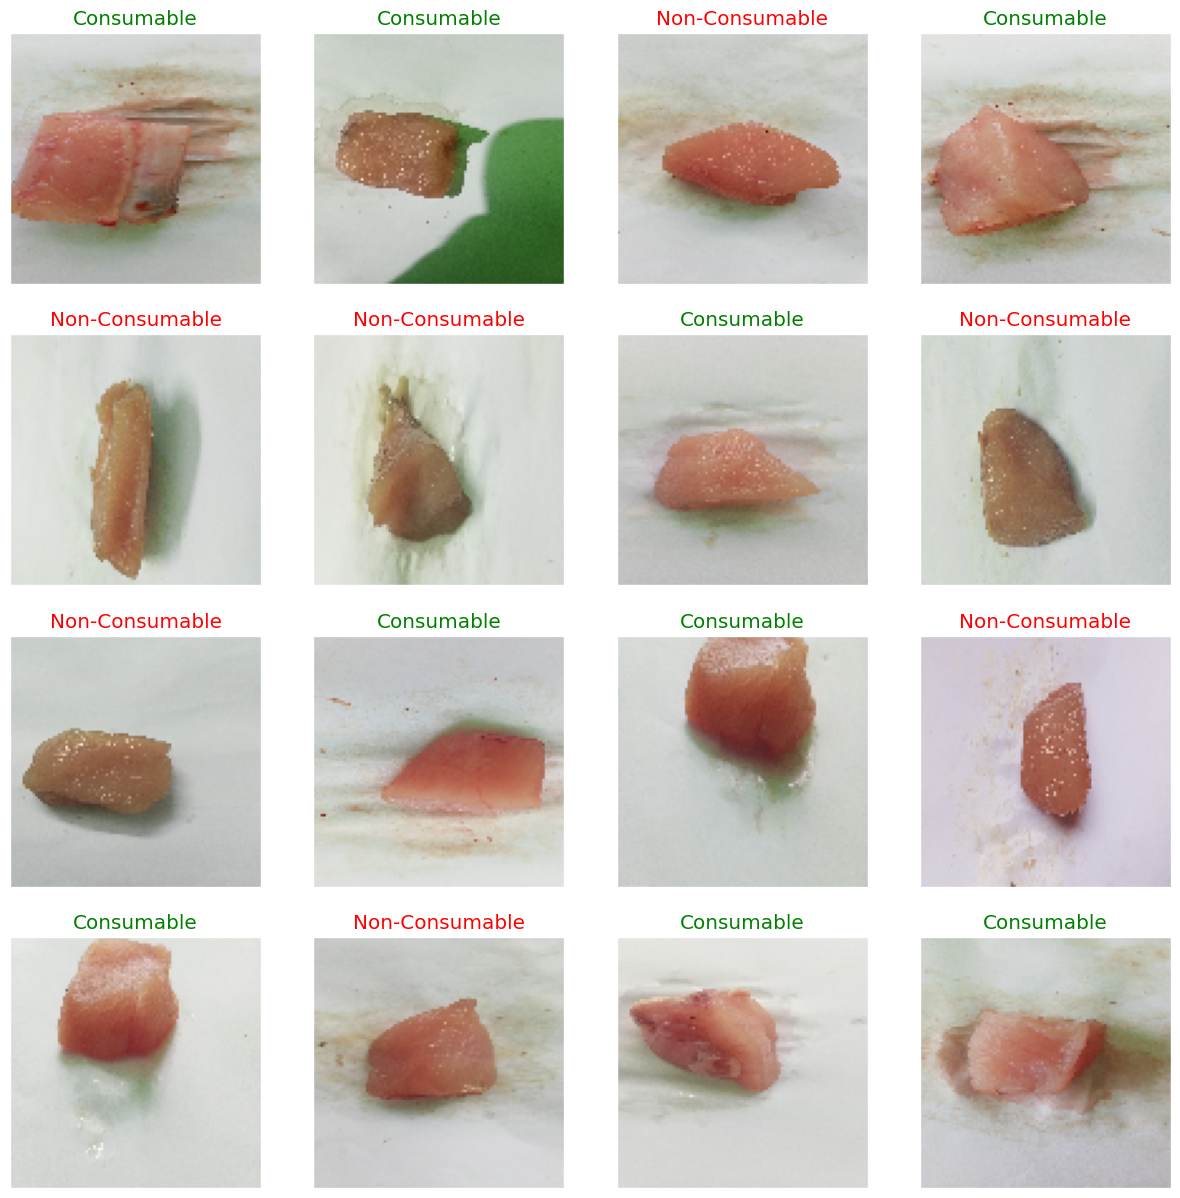

In [77]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='Consumable':
        c='green'
    else:
        c='red'
    plt.title(image_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [78]:
# Making labels for the data
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [79]:
# Transforming image_data rgb values within 0 to 1
X = image_data / 255.0
# Transforming labels to distinct integer values
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)

In [80]:
# ResNet model
def resnet_model(input_shape=(width,height,3)):
    # Load the ResNet50 model without the top layers
    resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Add custom top layers for classification
    x = layers.Flatten()(resnet.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = models.Model(inputs=resnet.input, outputs=predictions)

    # Freeze the ResNet50 layers
    for layer in resnet.layers:
        layer.trainable = False

    return model

# Create model
model = resnet_model()

# Training model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
7/7 [==============================] - 11s 1s/step - loss: 1.8293 - accuracy: 0.5253 - val_loss: 0.7710 - val_accuracy: 0.6022
Epoch 2/10
7/7 [==============================] - 6s 912ms/step - loss: 0.7061 - accuracy: 0.5576 - val_loss: 0.7130 - val_accuracy: 0.6022
Epoch 3/10
7/7 [==============================] - 6s 925ms/step - loss: 0.7066 - accuracy: 0.5853 - val_loss: 0.6882 - val_accuracy: 0.6022
Epoch 4/10
7/7 [==============================] - 6s 916ms/step - loss: 0.7580 - accuracy: 0.4608 - val_loss: 0.8299 - val_accuracy: 0.6022
Epoch 5/10
7/7 [==============================] - 6s 923ms/step - loss: 0.7035 - accuracy: 0.5207 - val_loss: 0.6335 - val_accuracy: 0.6129
Epoch 6/10
7/7 [==============================] - 6s 937ms/step - loss: 0.6464 - accuracy: 0.6406 - val_loss: 0.5998 - val_accuracy: 0.6452
Epoch 7/10
7/7 [==============================] - 7s 983ms/step - loss: 0.6155 - accuracy: 0.6590 - val_loss: 0.5889 - val_accuracy: 0.7742
Epoch 8/10
7/7 [======

3/3 - 2s - loss: 0.5684 - accuracy: 0.6452 - 2s/epoch - 603ms/step


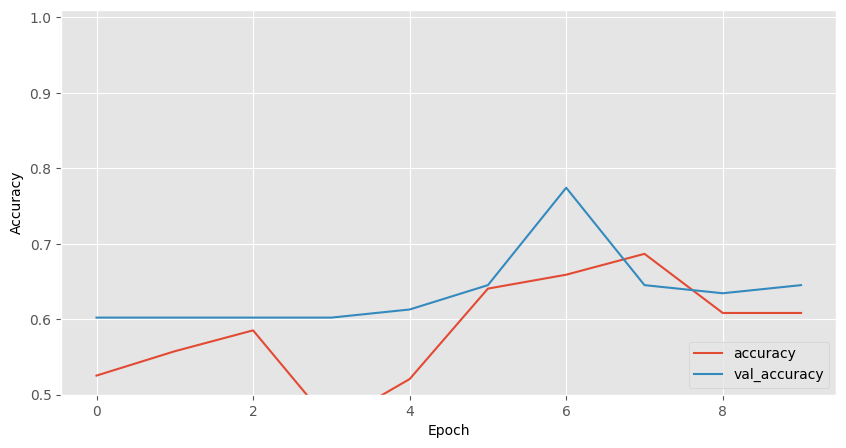

In [81]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [82]:
result=model.evaluate(test_images, test_labels)

3/3 [==============================] - 2s 588ms/step - loss: 0.5684 - accuracy: 0.6452


In [83]:
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i],":",result[i])

loss : 0.5684000849723816
accuracy : 0.6451612710952759


3/3 [==============================] - 3s 622ms/step


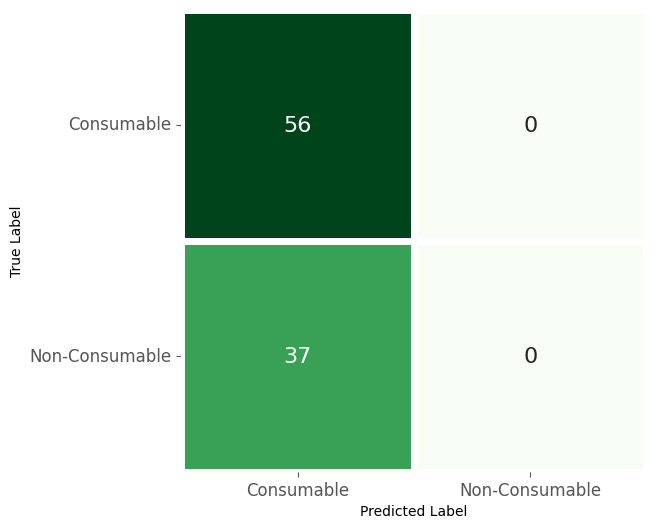

In [84]:
# Calculating Accuracy

y_pred = model.predict(test_images)

def toClass(pred):
    
    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index
        
    return class_

cm = confusion_matrix(test_labels,toClass(y_pred))

df1 = pd.DataFrame(columns=["Consumable","Non-Consumable"], index= ["Consumable","Non-Consumable"], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.show()

In [52]:
# Case 2: Prediction in HSV Color Space

In [85]:
# Preparing the dataset
files = ['Consumable', 'Non-Consumable']
address = '/media/debrc/Data/Codings/Meat-Gradation-PROJ/Dataset/Chicken/'

In [86]:
# Loading the image files based on classifications
data = {}
for f in files:
    data[f]=[]
for col in files:
    os.chdir(address+col)
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg'):
            data[col].append(i)

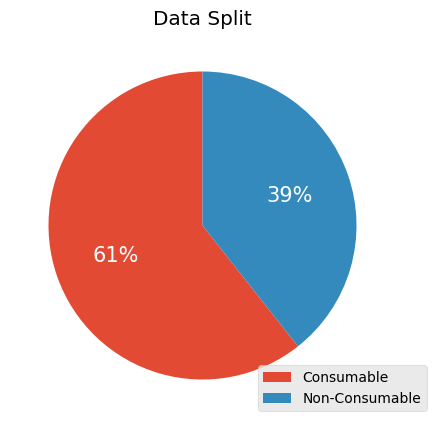

In [87]:
sizes = [len(data['Consumable']), len(data['Non-Consumable'])]
plt.figure(figsize=(10,5), dpi=100)
plt.pie(x=sizes,autopct='%1.0f%%',shadow=False, textprops={'color':"w","fontsize":15}, startangle=90)
plt.legend(files,bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [88]:
width = 100
height = 100

In [89]:
# Converting BGR Images to HSV Color Space
start = time.time()
image_data = []
image_target = []

for title in files:
    os.chdir(address+title)
    counter = 0
    for i in data[title]:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        image_data.append(cv2.resize(img,(width, height)))
        image_target.append(title)
        counter += 1
    clear_output(wait=True)
calculate_time = time.time() - start    
print("Calculate Time",round(calculate_time,5))

Calculate Time 30.74198


In [90]:
# Displaying the dimensionality of the array
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(310, 100, 100, 3)

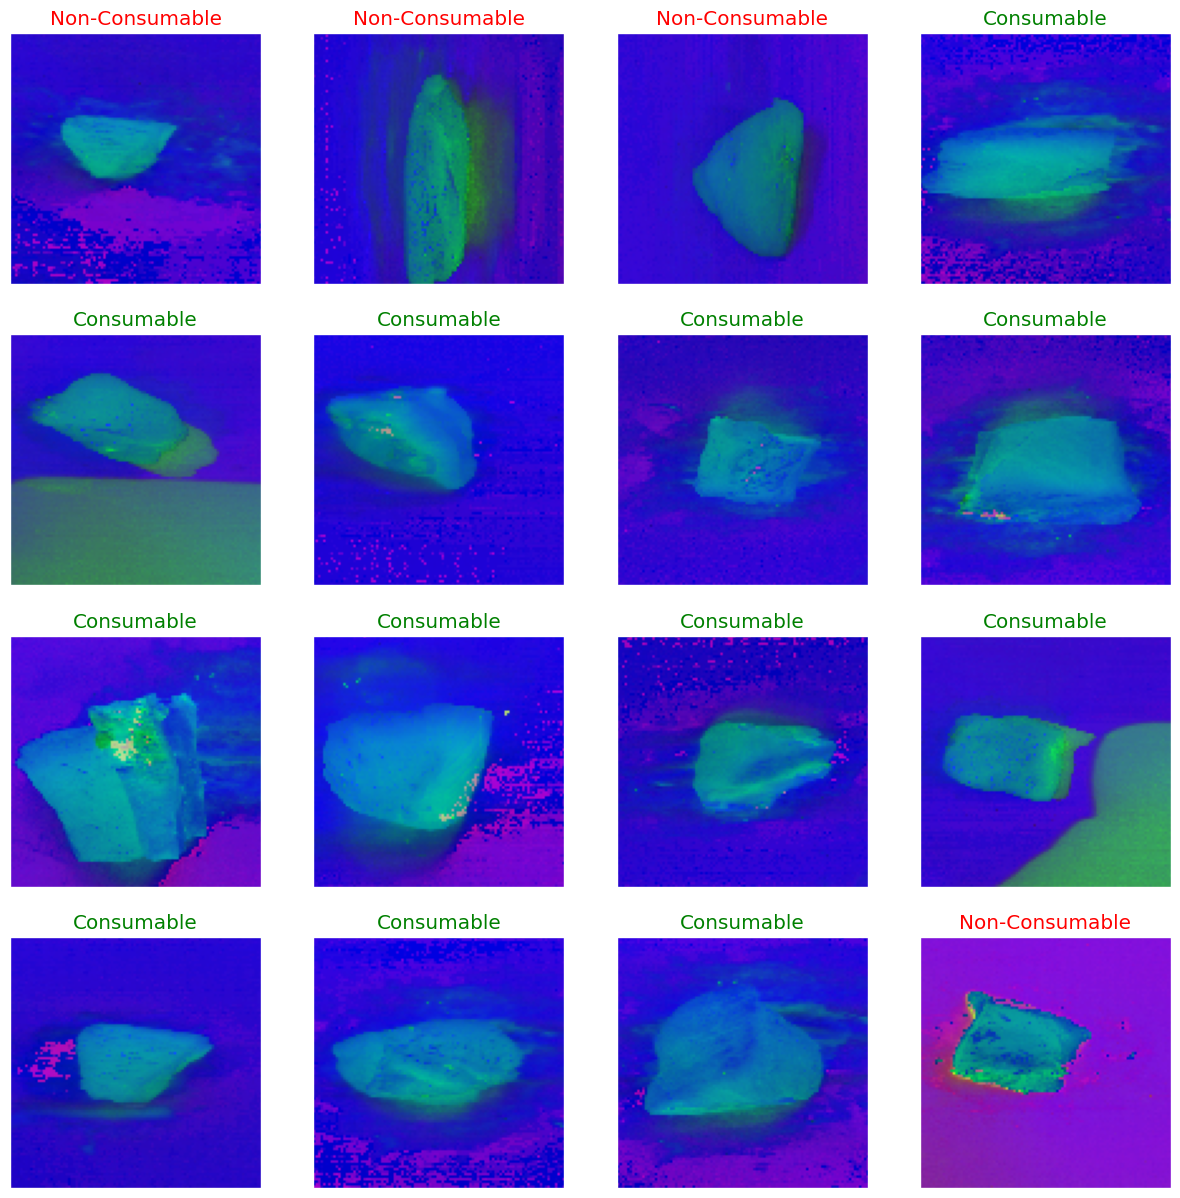

In [91]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='Consumable':
        c='green'
    else:
        c='red'
    plt.title(image_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [92]:
# Making labels for the data
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [93]:
# Transforming image_data rgb values within 0 to 1
X = image_data
# Transforming labels to distinct integer values
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)

In [94]:
# ResNet model
def resnet_model(input_shape=(width,height,3)):
    # Load the ResNet50 model without the top layers
    resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Add custom top layers for classification
    x = layers.Flatten()(resnet.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = models.Model(inputs=resnet.input, outputs=predictions)

    # Freeze the ResNet50 layers
    for layer in resnet.layers:
        layer.trainable = False

    return model

# Create model
model = resnet_model()

# Training model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
7/7 [==============================] - 11s 1s/step - loss: 3.5707 - accuracy: 0.6452 - val_loss: 1.6101 - val_accuracy: 0.8387
Epoch 2/10
7/7 [==============================] - 6s 934ms/step - loss: 2.0813 - accuracy: 0.7834 - val_loss: 1.9155 - val_accuracy: 0.7312
Epoch 3/10
7/7 [==============================] - 6s 913ms/step - loss: 1.3841 - accuracy: 0.8249 - val_loss: 1.7871 - val_accuracy: 0.8172
Epoch 4/10
7/7 [==============================] - 6s 970ms/step - loss: 0.4103 - accuracy: 0.9171 - val_loss: 0.8070 - val_accuracy: 0.8172
Epoch 5/10
7/7 [==============================] - 7s 959ms/step - loss: 0.3812 - accuracy: 0.9355 - val_loss: 0.7048 - val_accuracy: 0.8817
Epoch 6/10
7/7 [==============================] - 7s 976ms/step - loss: 0.2153 - accuracy: 0.9447 - val_loss: 0.3364 - val_accuracy: 0.8925
Epoch 7/10
7/7 [==============================] - 7s 1s/step - loss: 0.1902 - accuracy: 0.9493 - val_loss: 0.7119 - val_accuracy: 0.8602
Epoch 8/10
7/7 [=========

3/3 - 2s - loss: 0.6633 - accuracy: 0.8710 - 2s/epoch - 669ms/step


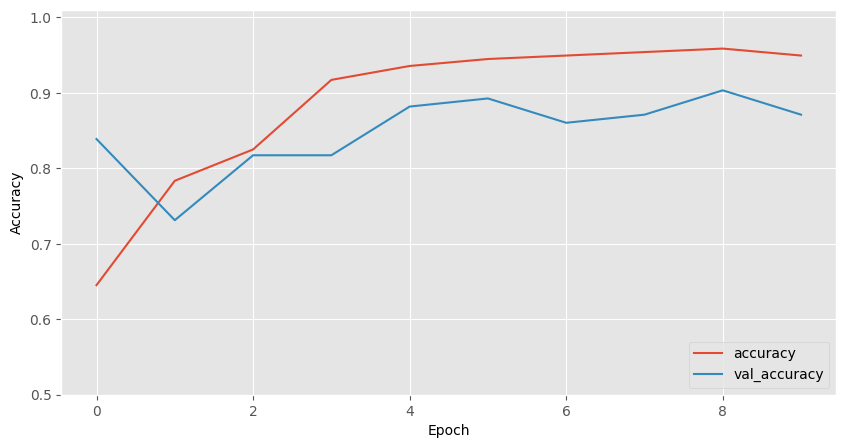

In [95]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [96]:
result=model.evaluate(test_images, test_labels)

3/3 [==============================] - 2s 667ms/step - loss: 0.6633 - accuracy: 0.8710


In [97]:
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i],":",result[i])

loss : 0.6632977724075317
accuracy : 0.8709677457809448


3/3 [==============================] - 3s 626ms/step


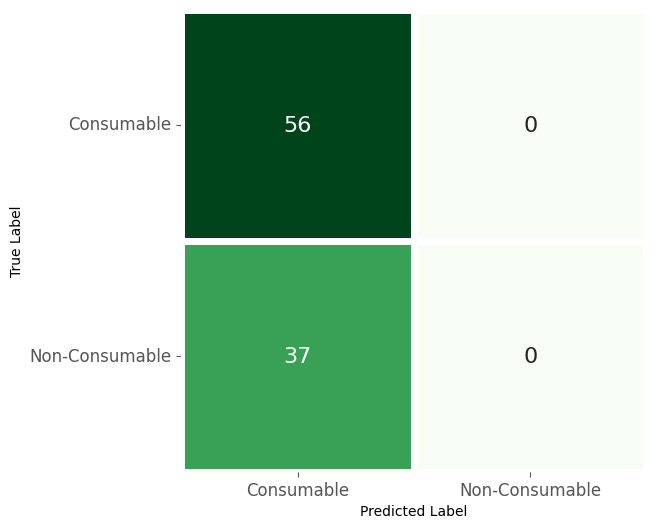

In [98]:
# Calculating Accuracy

y_pred = model.predict(test_images)

def toClass(pred):
    
    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index
        
    return class_

cm = confusion_matrix(test_labels,toClass(y_pred))

df1 = pd.DataFrame(columns=["Consumable","Non-Consumable"], index= ["Consumable","Non-Consumable"], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.show()